# Image compression/generation with Variational AutoEncoder

In [33]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


# Download dataset and define the model

In [34]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 128
epochs = 10
learning_rate = 1e-3
latent_dim = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mu
        self.fc22 = nn.Linear(400, latent_dim)  # logvar
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantiate the model
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# Model training

In [35]:
# Training loop
def train():
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss
    

# Run the training
bar = tqdm(range(epochs), total=epochs, desc='Training model')
for _ in range(epochs):
    loss = train()
    bar.set_postfix(Loss=loss)
    bar.update(1)


Training model:   0%|          | 0/10 [00:00<?, ?it/s]

# Compress and Reconstruct images

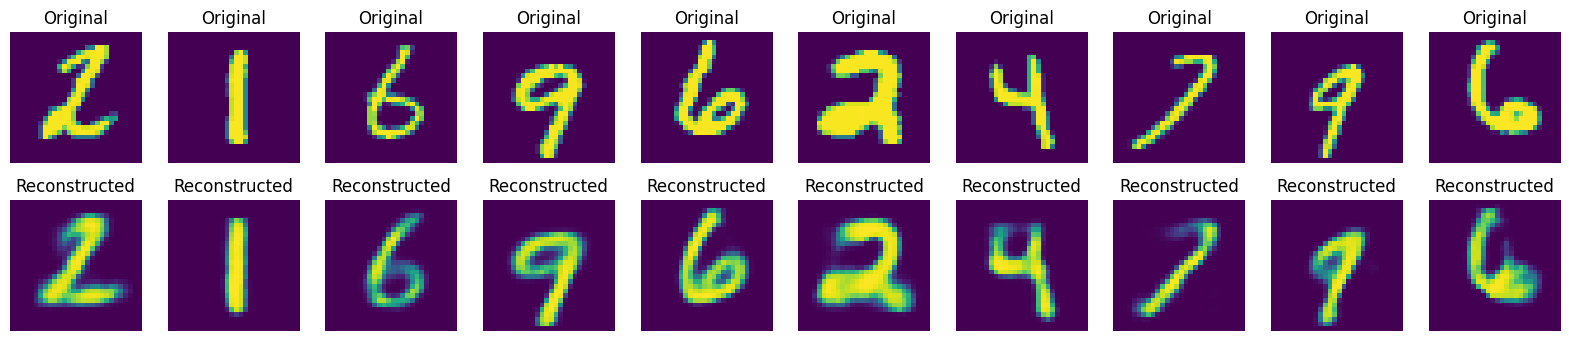

In [36]:
# Function to compress and reconstruct images
def compress_and_reconstruct(model, data):
    with torch.no_grad():
        data = data.to(device)
        mu, logvar = model.encode(data.view(-1, 784))
        z = model.reparameterize(mu, logvar)
        recon_batch = model.decode(z).view(data.shape[0], 28, 28)
    return data.cpu(), recon_batch.cpu()

# Get a batch of test images
data_iter = iter(test_loader)
images, _ = next(data_iter)

# Compress and reconstruct the images
original_images, reconstructed_images = compress_and_reconstruct(model, images)

# Visualize the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].permute((1, 2, 0)))
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

Now we will retrain the model but this time using a latent dimension of 2. This is for visualization puposes so we can see the effect of changing the latent dimension values on the generated images.

In [37]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 20
bar = tqdm(range(epochs), total=epochs, desc='Training model')

for _ in range(epochs):
    loss = train()
    scheduler.step()
    bar.set_postfix(Loss=loss, LR=optimizer.param_groups[0]['lr'])
    bar.update(1)

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

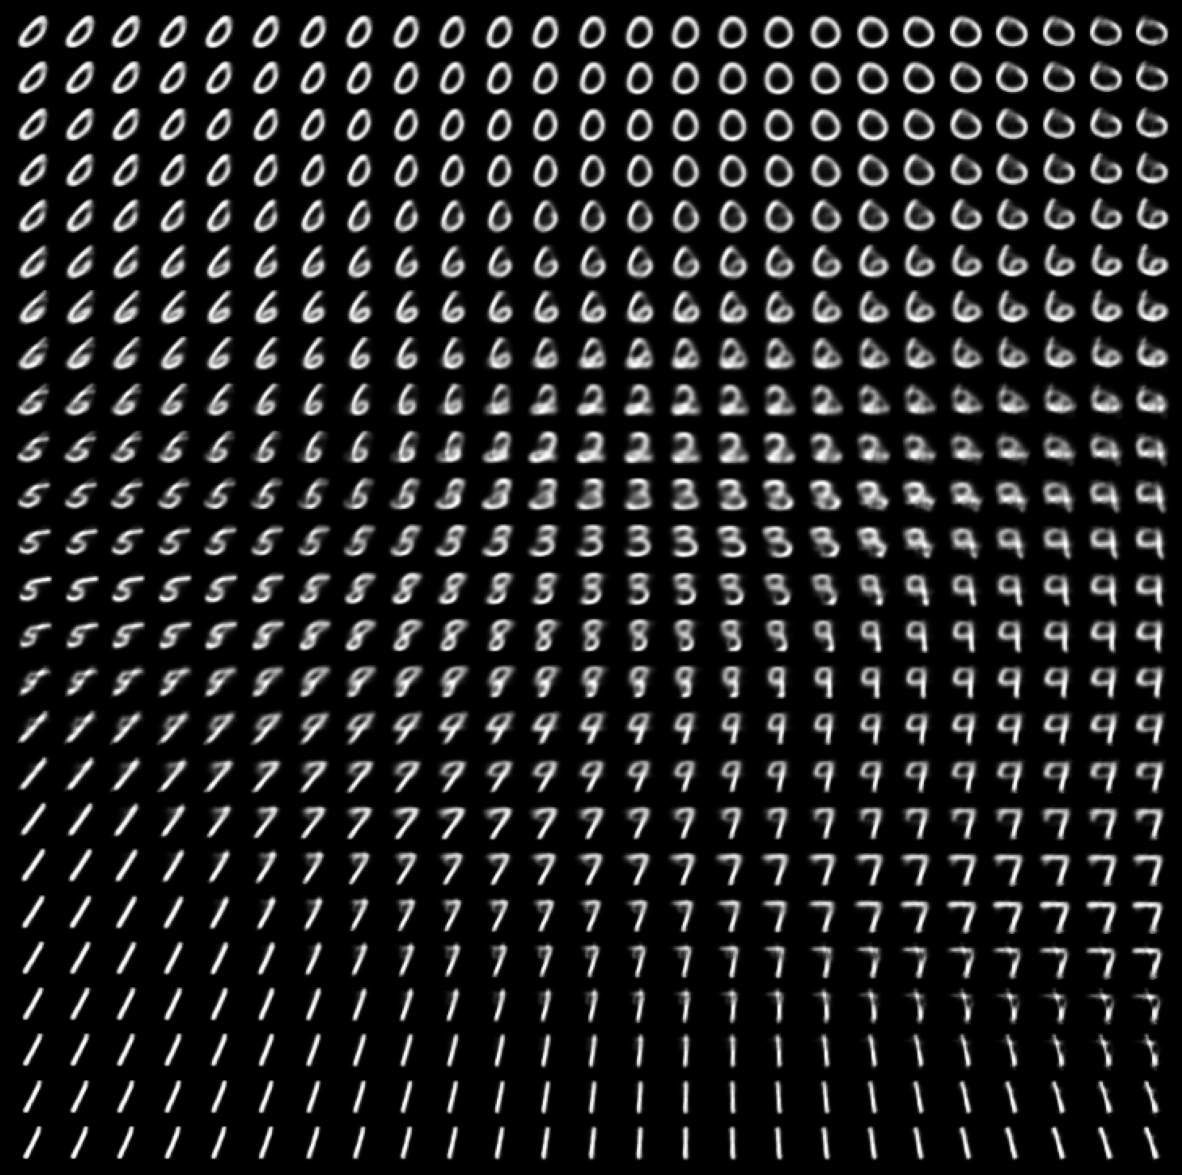

In [38]:
def generate_2d_grid_plot(x_range=(-2.5, 2.5), y_range=(-2.5, 2.5), n=25):
    x = np.linspace(x_range[0], x_range[1], n)
    y = np.linspace(y_range[0], y_range[1], n)

    # Create the grid plot
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    fig.patch.set_facecolor('black')
    
    with torch.no_grad():
        for i, yi in enumerate(y):
            for j, xi in enumerate(x):
                z = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
                generated = model.decode(z).view(28, 28)
                axes[i, j].imshow(generated.cpu().numpy(), cmap='gray')
                axes[i, j].axis('off')
                
                # Set the ticks for the leftmost column
                if j == 0:
                    axes[i, j].set_yticks([0])
                    axes[i, j].set_yticklabels([f"{yi:.1f}"])
                    
                # Set the ticks for the bottom row
                if i == n - 1:
                    axes[i, j].set_xticks([0])
                    axes[i, j].set_xticklabels([f"{xi:.1f}"])
    
    # Adjust layout
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Generate and display the 2D grid plot
generate_2d_grid_plot()



# Denoising

In [39]:
def add_noise(img, percentage=0.1):
    """
    Add random uniform noise to a percentage of the image's pixels.

    Parameters:
    - img (torch.Tensor): The original image tensor.
    - percentage (float): The fraction of pixels to which noise should be applied. Value between 0 and 1.

    Returns:
    - torch.Tensor: The noisy image.
    """
    # Ensure the percentage value is within the correct range
    assert 0 <= percentage <= 1, "Percentage must be between 0 and 1."

    # Create a random mask to select a subset of pixels based on the percentage
    mask = torch.rand(img.size()) < percentage

    # Generate uniform noise only where the mask is True
    # Noise scaled to [-1, 1] to simulate a wider range of noise
    noise = (torch.rand(img.size()) * 2) - 1
    noisy_img = img.clone()  # Make a copy to avoid modifying the original image
    noisy_img[mask] += noise[mask]

    # Clamp the values to ensure they are still valid image pixels
    return torch.clamp(noisy_img, 0., 1.)


class NoisyMNIST(Dataset):
    def __init__(self, mnist_dataset, noise_percentage=0.1):
        self.mnist_dataset = mnist_dataset
        self.noise_percentage = noise_percentage

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        original, _ = self.mnist_dataset[idx]  # original is clean
        noisy = add_noise(original, percentage=self.noise_percentage)
        return noisy, original  # return both noisy and clean image


# Example transformation and dataset initialization
def create_noisy_dataset(noise_percentage: float=0.1):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_noisy_dataset = NoisyMNIST(train_dataset, noise_percentage=noise_percentage)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_noisy_dataset = NoisyMNIST(test_dataset, noise_percentage=noise_percentage)

    train_loader = DataLoader(dataset=train_noisy_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_noisy_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# Plot the first 5 noisy images
def plot_images(loader):
    for images, _ in loader:
        plt.figure(figsize=(10, 2))
        for i, image in enumerate(images):
            if i >= 5:
                break
            plt.subplot(1, 5, i + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()
        break  # Only show the first batch

In [40]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for noisy_data, original_data in train_loader:
        original_data = original_data.to(device)
        noisy_data = noisy_data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(noisy_data)
        loss = loss_function(recon_batch, original_data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

In [41]:
def remove_noise(model, test_loader):
    model.eval()
    with torch.no_grad():
        for noisy_data, _ in test_loader:
            noisy_data = noisy_data.to(device)
            recon_batch, _, _ = model(noisy_data)
            return noisy_data.cpu(), recon_batch.cpu().view(recon_batch.shape[0], 1, 28, 28)
        
def plot_noisy_vs_original(n, noise_percentage, test_loader):
    # Remove noise from the images
    noisy_images, denoised_images = remove_noise(model, test_loader)

    # Visualize the results
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'Noisy vs. Denoised Images (Noise Percentage = {noise_percentage})', fontsize=18)
    for i in range(n):
        # Display noisy images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        plt.axis('off')

        # Display denoised images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(denoised_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

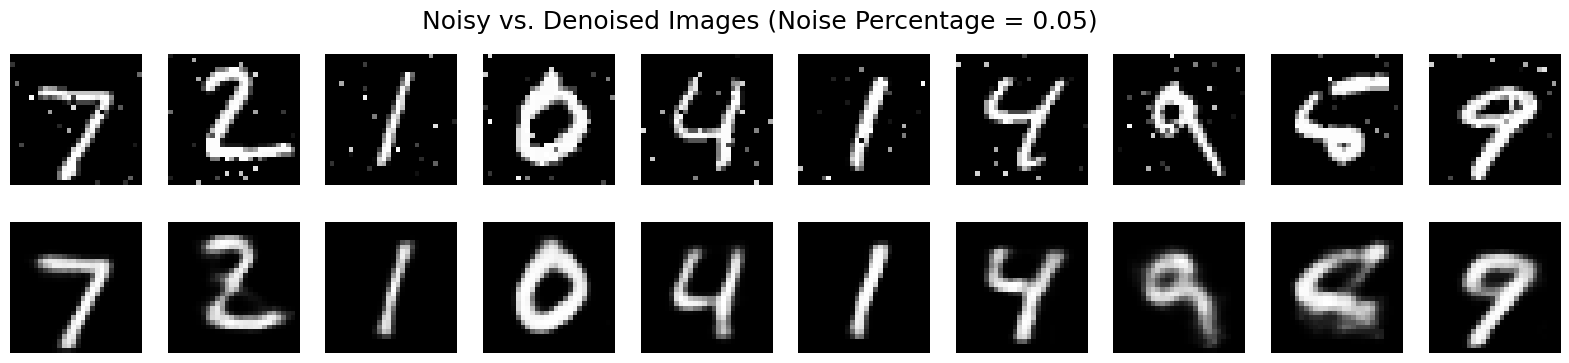

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

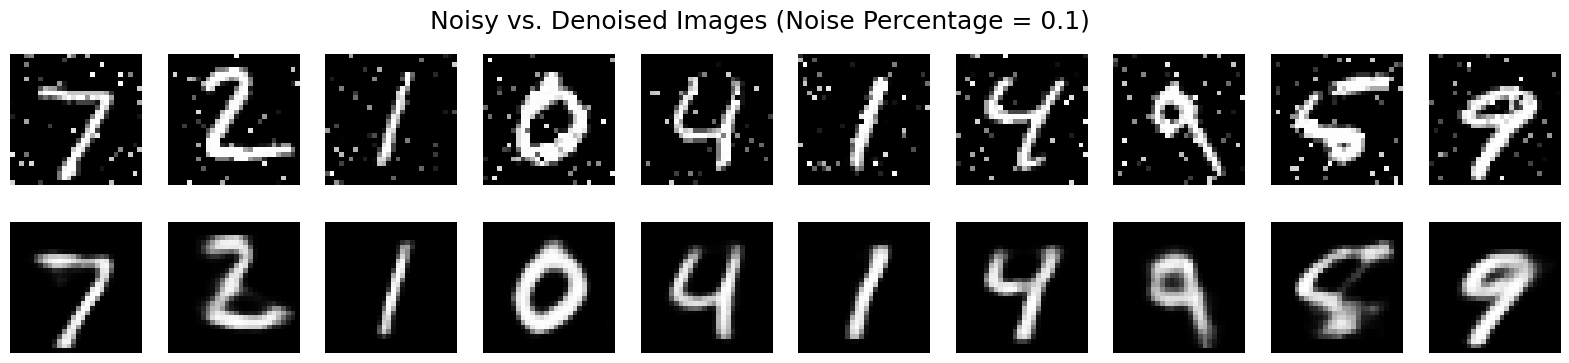

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

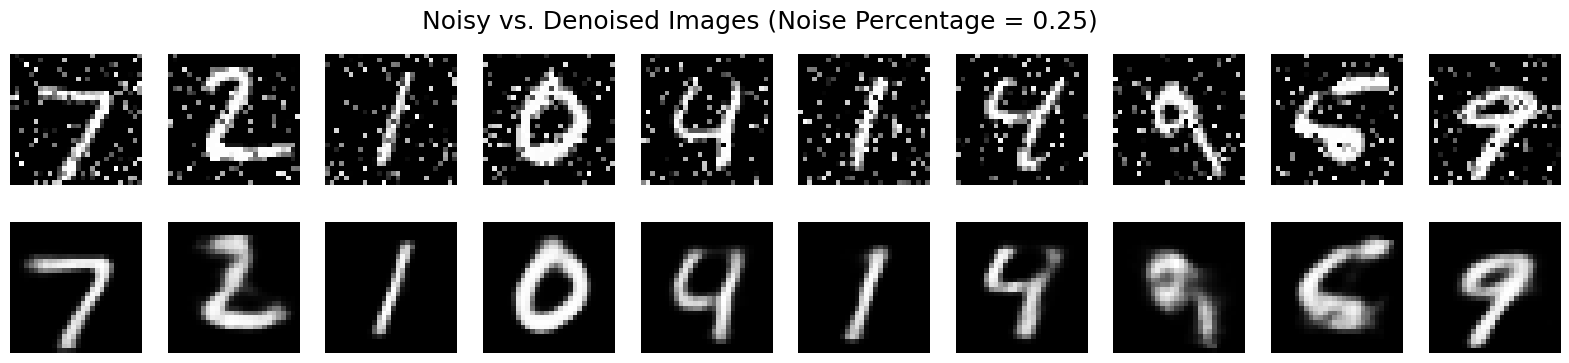

Training model:   0%|          | 0/20 [00:00<?, ?it/s]

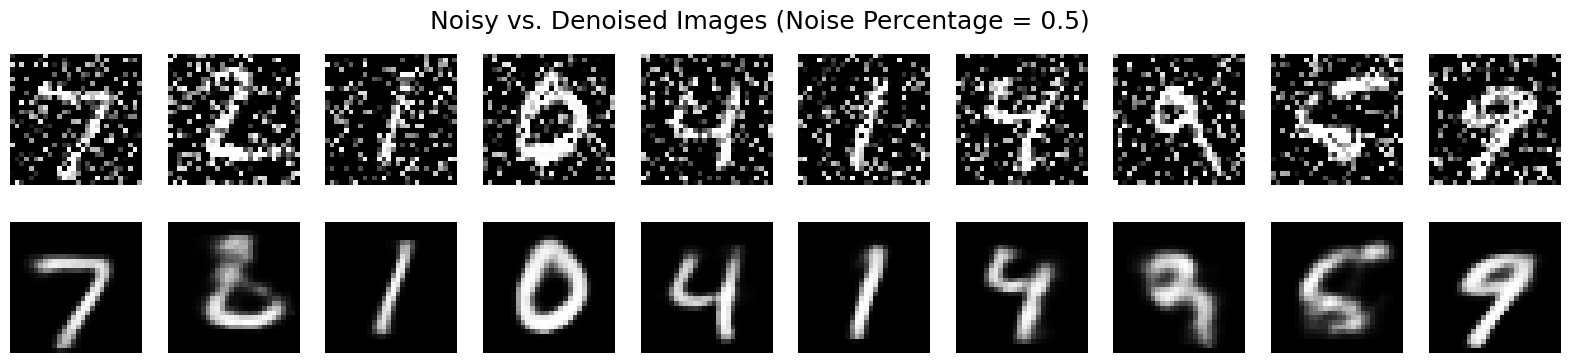

In [42]:
percentages = [0.05, 0.1, 0.25, 0.5]
losses = []
for p in percentages:
    model = VAE(latent_dim=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_loader, test_loader = create_noisy_dataset(noise_percentage=p)
    epochs = 20
    bar = tqdm(range(epochs), total=epochs, desc='Training model')

    for _ in range(epochs):
        loss = train(model, train_loader, optimizer)
        bar.set_postfix(Loss=loss)
        bar.update(1)
    losses.append(loss)
    plot_noisy_vs_original(10, noise_percentage=p, test_loader=test_loader)


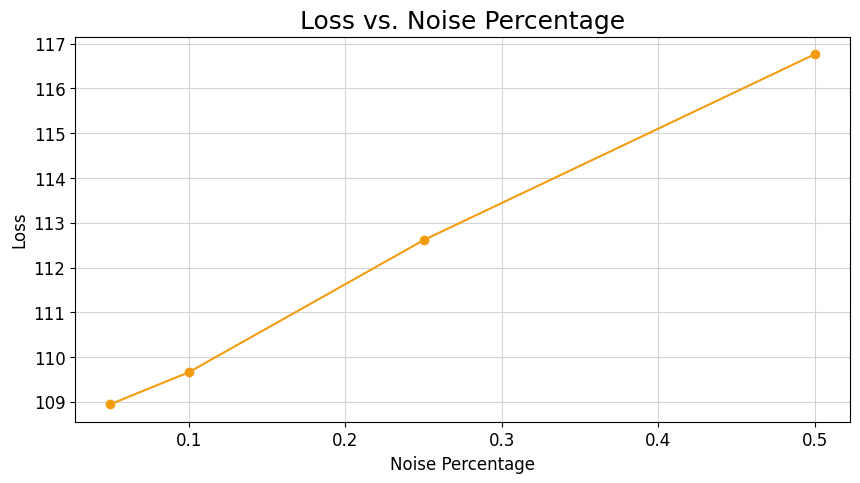

In [43]:
plt.rcParams.update({
    'font.family': 'sans-serif',  # Use a serif font
    'font.serif': ['Helvetica'],  # Specific font
    'grid.color': '#d4d4d4',  # Light gray grid lines
    'axes.edgecolor': '#000000',  # Black edge color for axes
    'axes.labelsize': 12,  # Axis label font size
    'xtick.labelsize': 12,  # X-tick label font size
    'ytick.labelsize': 12,  # Y-tick label font size
    'legend.fontsize': 10,  # Legend font size
})
plt.figure(figsize=(10, 5))
plt.plot(percentages, losses, marker='o', color='#F39C12')
plt.xlabel('Noise Percentage')
plt.ylabel('Loss')
plt.title('Loss vs. Noise Percentage', fontsize=18)
plt.grid()
plt.show()